In [205]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path

In [206]:
def unique(myList): return sorted(list(set(myList)))
def get_df_from_path(hdf5filePath):
    h = h5py.File(hdf5filePath, 'r+')
    history = h['history']
    colnames = history.attrs['column_names']
    assert len(history) == len(colnames)
    nbcols = len(colnames)
    _ = dict()
    for i, colname in zip(range(nbcols), colnames):
        _[colname] = history[i]
    return pd.DataFrame(_)

def get_info_from_path(hdf5filePath):
    #'HDF5Files/toyRates_logM-0.1_X0.6.hdf5' is a filepath, get logM and X from it
    logM = float(hdf5filePath.split('logM')[1].split('_')[0])
    X = float(hdf5filePath.split('X')[1].split('_')[0])
    return logM, X

def get_µ_from_X(X): return 4 / ( 3 + 5*X )
def get_X_from_µ(µ): return ( 4 - 3*µ ) / ( 5*µ )
#benadering: M(H1) is niet helemaal 1, en dan nog isotopenbenadering en Z = A/2 ofzo enzo

class Track:    
    def __init__(self, hdf5filePath, H_cutoff = 0.999, Temp_reference = 10**3.0):
        self.path = hdf5filePath
        self.history = get_df_from_path(hdf5filePath)
        self.logM, self.X = get_info_from_path(hdf5filePath)
        self.M = 10**self.logM
        self.Mround = round(self.M, 1)
        self.µ = get_µ_from_X(self.X)
        self.ZAMS_L = None
        self.PMS_L = None
        self.ZAMS_index = self.compute_ZAMS_index(H_cutoff)
        self.PMS_index = self.compute_PMS_index(Temp_reference)

    def compute_ZAMS_index(self, H_cutoff=0.999):
        try:
            index = np.where(self.history.X_center < H_cutoff * self.history.X_center[0])[0][0]
        except:
            return None
        self.ZAMS_index = index
        self.ZAMS_index_calculated = True
        self.ZAMS_L = self.history.L_surf[self.ZAMS_index]
        return index

    def compute_PMS_index(self, Temp_reference = 10**3.0):
        if self.X != 0 and self.ZAMS_index == None:
            return None
        try:
            index = np.argmin(self.history.T_surf[0:self.ZAMS_index] - Temp_reference)
            self.PMS_index = index
            self.PMS_L = self.history.L_surf[self.PMS_index]
        except:
            return None
        return index
    
    def compute_indices(self, H_cutoff=0.999, Temp_reference = 10**3.0):
        self.compute_ZAMS_index(H_cutoff)
        self.compute_PMS_index(Temp_reference)
    
    def get_gridpoint(self):
        return (self.logM, self.X)
    
    def plot_HRD_PMS(self, ax=None):
        if ax == None:
            fig, ax = plt.subplots()
        ax.set_title('HRD')
        ax.set_xlabel('log(Teff)')
        ax.set_ylabel('log(L)')
        ax.plot(np.log10(self.history.T_surf), np.log10(self.history.L_surf), label=self.path)
        ax.invert_xaxis()
        return ax
import time
class Grid:
    def __init__(self, tracks):
        self.tracks = tracks
        self.gridpoints = [track.get_gridpoint() for track in tracks]

        print('Grid with', len(self.tracks), 'tracks', end="\r")
        #time.sleep(0.05)
        self.logMs = np.array([track.logM for track in tracks])
        self.Ms = np.array([track.M for track in tracks])
        self.Xs = np.array([track.X for track in tracks])
        self.µs = np.array([track.µ for track in tracks])
        self.ZAMS_Ls = np.array([track.ZAMS_L for track in tracks])
        self.PMS_Ls = np.array([track.PMS_L for track in tracks])
        self.failed_tracks = [track for track in tracks if track.ZAMS_index == None]
        #nb of logMs:
        self.nb_logMs = len(set(self.logMs))
    def get_info(self):
        print('Grid with', len(self.tracks), 'tracks')
        print('logMs:', self.logMs)
        print('Xs:', self.Xs)
        print('µs:', self.µs)
    def generate_cut_grid(self, logM_lo, logM_hi, X_lo, X_hi):
        return Grid([track for track in self.tracks if logM_lo <= track.logM <= logM_hi and X_lo <= track.X <= X_hi])
    def generate_cut_grid_µ(self, µ_lo, µ_hi):
        return Grid([track for track in self.tracks if µ_lo <= track.µ <= µ_hi])
    def collapse_grid_logM(self, logM):
        return Grid([track for track in self.tracks if track.logM == logM])
    def collapse_grid_X(self, X):
        return Grid([track for track in self.tracks if track.X == X])
    
    def colors_and_shapes(self):
        colors = plt.cm.viridis(np.linspace(0, 1, self.nb_logMs))
        colors = {np.round(logM,1):color for logM, color in zip(unique(self.logMs), colors)}
        shapes = ['o','s','*','X','D']
        shapes = {np.round(logM,1) : shapes[i%len(shapes)] for i, logM in enumerate(sorted(list(set(self.logMs))))}
        return colors, shapes
    def HRD_things(self, ax = None):
        colors, shapes = self.colors_and_shapes()
        if ax == None:
            fig, ax = plt.subplots()
        ax.set_title('HR Diagram')
        ax.set_xlabel('$ \log(T_{eff} / K) $')
        ax.set_ylabel('$ \log(L / L_{\odot}) $')
        ax.invert_xaxis()
        return ax, colors, shapes
    
    def plot_HRD(self, ax = None):
        ax, colors, shapes = self.HRD_things(ax)
        for track in self.tracks:
            ax.plot(np.log10(track.history.T_surf), np.log10(track.history.L_surf), label=track.get_gridpoint())
            if track.ZAMS_index != None:
                ax.scatter(np.log10(track.history.T_surf[track.ZAMS_index]), np.log10(track.history.L_surf[track.ZAMS_index]))
        return ax

    def plot_HRD_PMS(self, ax=None):
        ax, colors, shapes = self.HRD_things(ax)   
        if ax == None: fig, ax = plt.subplots()
        for index, track in enumerate(self.tracks):
            if track.ZAMS_index == None:
                continue
            ax.plot(np.log10(track.history.T_surf[0:track.ZAMS_index]), np.log10(track.history.L_surf[0:track.ZAMS_index]), color = colors[track.logM])
            #scatter zams
            ax.scatter(np.log10(track.history.T_surf[track.ZAMS_index]), np.log10(track.history.L_surf[track.ZAMS_index]), color = colors[track.logM], marker = shapes[track.logM])
        return ax
    
    def plot_grid(self, ax = None ):
        colors, shapes = self.colors_and_shapes() 
        if ax == None: fig, ax = plt.subplots()
        ax.set_title('Grid')
        ax.set_xlabel('Mass $\log(M/M_{\odot})$')
        ax.set_ylabel('Hydrogen fraction X')
        for track in self.tracks:
            marker = 'x' if track.PMS_L == None else 'o'       
            ax.scatter(track.logM, track.X, color = colors[track.logM], marker = marker)
        secax = ax.secondary_yaxis('right', functions=(get_µ_from_X, get_X_from_µ))
        secax.set_ylabel('Mean molecular weight $\mu$', rotation=270, labelpad=15)

In [207]:
p = Path('.')
_ = list(p.glob('Histories_withoutPrad/*.hdf5'))
paths = [str(hdf5file) for hdf5file in _]
tracks = [Track(path) for path in paths]
totalGrid = Grid(tracks)

/tmp/ipykernel_785/42344217.py:20: RuntimeWarning: divide by zero encountered in divide
  def get_X_from_µ(µ): return ( 4 - 3*µ ) / ( 5*µ )


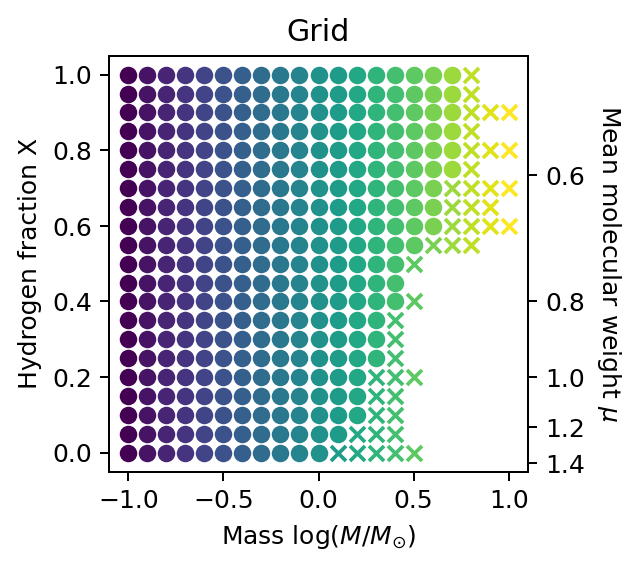

In [208]:
fig, ax = plt.subplots(1,1, figsize=(3,3),dpi=180)
totalGrid.plot_grid(ax)

In [209]:
#make a good grid
goodGrid = Grid([track for track in tracks if track.PMS_L != None])
badGrid = Grid([track for track in tracks if track.PMS_L == None])

<Axes: title={'center': 'HR Diagram'}, xlabel='$ \\log(T_{eff} / K) $', ylabel='$ \\log(L / L_{\\odot}) $'>

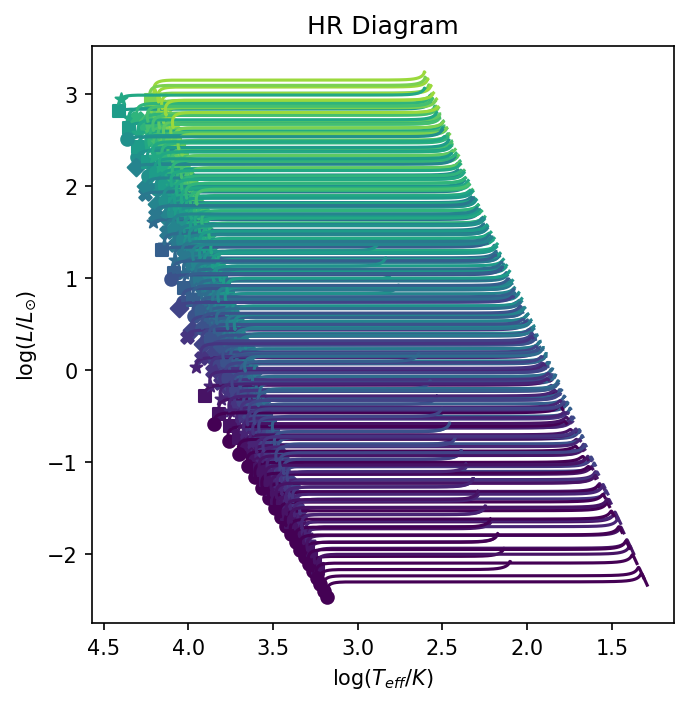

In [210]:
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=150)
totalGrid.plot_HRD_PMS(ax)

<Axes: title={'center': 'HR Diagram'}, xlabel='$ \\log(T_{eff} / K) $', ylabel='$ \\log(L / L_{\\odot}) $'>

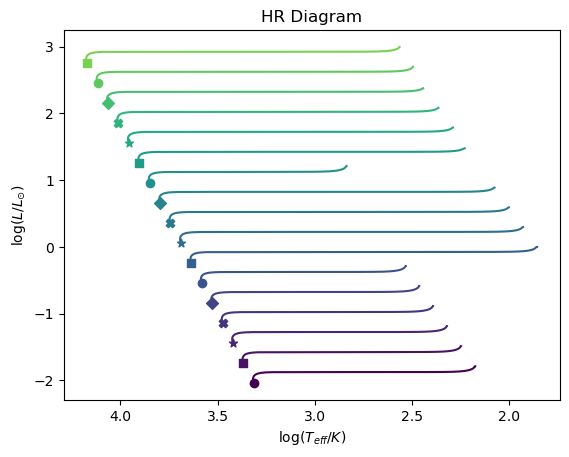

In [211]:
totalGrid.collapse_grid_X(0.7).plot_HRD_PMS()

<Axes: title={'center': 'HR Diagram'}, xlabel='$ \\log(T_{eff} / K) $', ylabel='$ \\log(L / L_{\\odot}) $'>

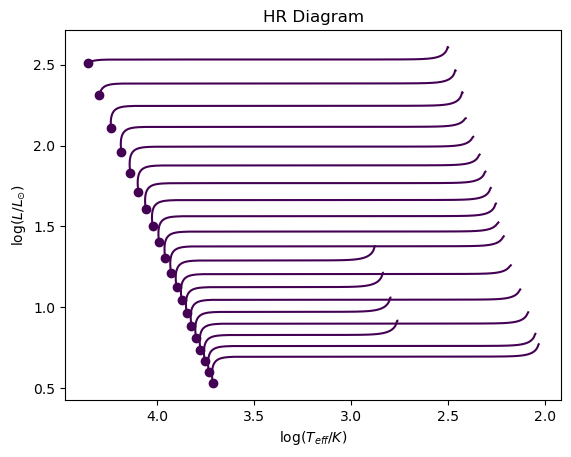

In [212]:
totalGrid.collapse_grid_logM(0.0).plot_HRD_PMS()

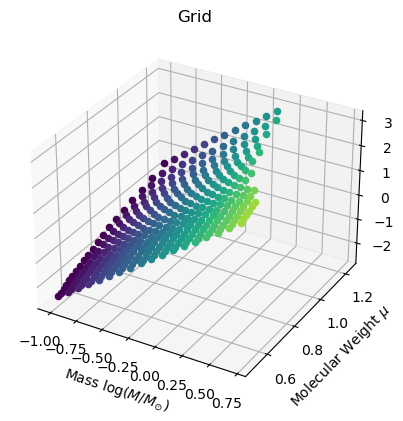

In [213]:
#%matplotlib widget 
#make a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Mass $\log(M/M_{\odot})$')
ax.set_ylabel('Molecular Weight $\mu$')
ax.set_zlabel('Luminosity at ZAMS $\log(L/L_{\odot})$')
ax.set_title('Grid')
for track in totalGrid.tracks:
    colors, shapes = totalGrid.colors_and_shapes()
    if track.ZAMS_L == None: continue
    ax.scatter(track.logM, track.µ, np.log10(track.ZAMS_L), color = colors[track.logM], marker = 'o')


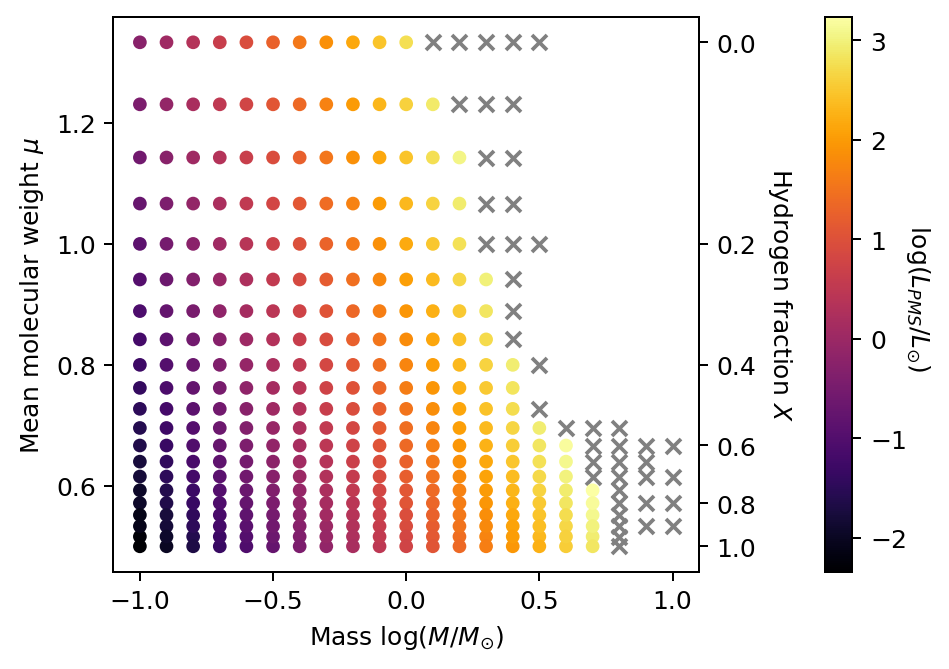

In [214]:
# Create a wider figure
fig = plt.figure(figsize=(6, 4),dpi=180)

# Add a subplot to this figure, leaving space on the right
ax = fig.add_subplot(111)

ax.scatter(badGrid.logMs, badGrid.µs, color = 'gray', marker = 'x')
#make colors based on totalGrid.ZAMS_Ls
colors =  np.log10(goodGrid.PMS_Ls)
plotting = ax.scatter(goodGrid.logMs, goodGrid.µs, c = colors, cmap = 'inferno',s=20)
# Add a colorbar to the figure
cbar = fig.colorbar(plotting, ax=ax, pad=0.15)
cbar.set_label(' $\log(L_{PMS}/L_{\odot})$',rotation=270,labelpad=10)

ax.set_xlabel('Mass $\log(M / M_{\odot})$')
ax.set_ylabel('Mean molecular weight $\mu$')

secax = ax.secondary_yaxis('right', functions=(get_X_from_µ,get_µ_from_X))
secax.set_ylabel('Hydrogen fraction $X$', rotation=270, labelpad=15)
ax.set_xticks(np.arange(-1,1.1,0.5))

# Analysis


In [215]:
import lmfit
from scipy import stats

## One single (3D) fit 

### L Model

The model: 
$L(X,M) = c_1 g(X)^{c_2} M^{c_3}$
where $g(X) = (3+5X)^4(1+X)$.
We would like that $c_2 = -1$ and $c_3 = 3$.

In [216]:
def L_model(X, M, c1, c2,c3):
    g = (3+5*X)**4*(1+X)
    return c1 * g**c2  * M**c3
model1 = lmfit.Model(L_model, independent_vars = ['X', 'M'])
model1.set_param_hint('c1', value=1, min=0)
model1.set_param_hint('c2', value=-1, min=-10, max=10)
model1.set_param_hint('c3', value=3, min=-5, max = 10)
fit1 = model1.fit(goodGrid.PMS_Ls, X = goodGrid.Xs, M = goodGrid.Ms)
fit1

In [217]:
sigma = stats.norm.ppf(0.995)
print(fit1.ci_report(sigmas = [1,2,sigma], with_offset=False))

       99.00%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.00%
 c1:51251.6006951556.2702852086.2579552619.5221253158.4851053705.9356954025.99266
 c2:  -1.02966  -1.02843  -1.02631  -1.02420  -1.02210  -1.01999  -1.01876
 c3:   3.06886   3.07196   3.07732   3.08267   3.08803   3.09341   3.09654


### log L model
$\log L (X, \log M) = A + c_2 \log g(X) + c_3 \log M$
where $A = \log c_1$, $g(X) = (3+5X)^4(1+X)$

In [218]:
def logL_model(X, M, A, c2,c3):
    g = (3+5*X)**4*(1+X)
    return A + c2 * np.log10(g) + c3 * np.log10(M)
    
model2 = lmfit.Model(logL_model, independent_vars = ['X', 'M'])
model2.set_param_hint('A', value=1, min=0)
model2.set_param_hint('c2', value=-1, min=-10, max=10)
model2.set_param_hint('c3', value=3, min=-5, max = 10)
fit2 = model2.fit(np.log10(goodGrid.PMS_Ls), X = goodGrid.Xs, M = goodGrid.Ms)
fit2

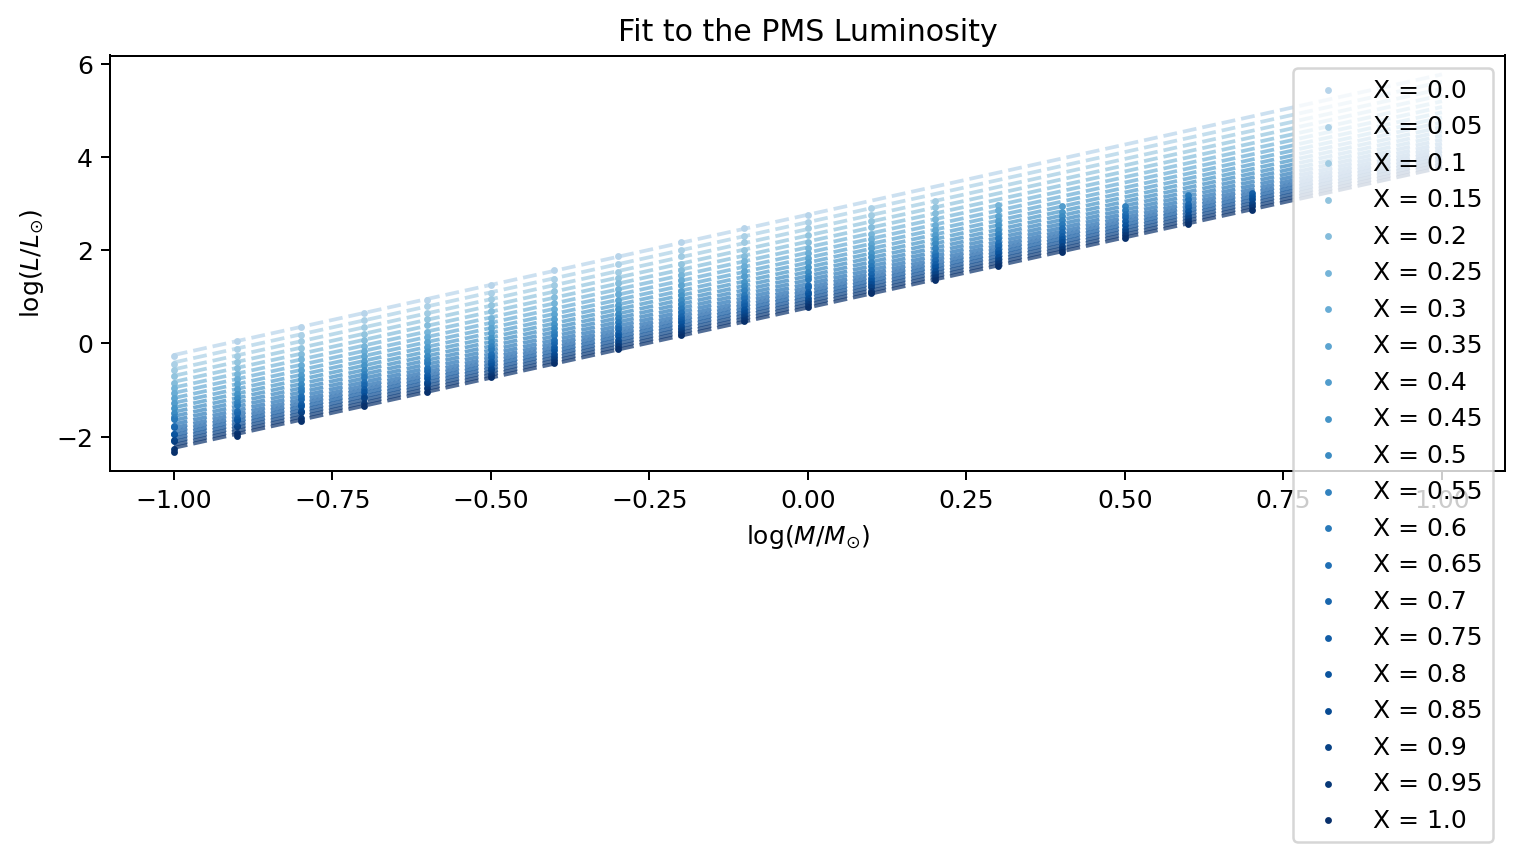

In [219]:
#make plot of the fit
fig, ax = plt.subplots(1,1, figsize=(10,3),dpi=180)
ax.set_title('Fit to the PMS Luminosity')
ax.set_xlabel('$\log(M/M_{\odot})$')
ax.set_ylabel('$\log(L/L_{\odot})$')

logMrange = np.linspace(-1,1,100)
Xs = unique(goodGrid.Xs)
#Xs = [0.6,0.7,0.9]
colors = plt.cm.Blues(np.linspace(0.3, 1, len(Xs)))
for X, color in zip(Xs,colors):
    cutGrid = goodGrid.collapse_grid_X(X)
    ax.scatter(cutGrid.logMs, np.log10(cutGrid.PMS_Ls), label = f'X = {X}', marker = 'o',color=color,s=3)
    ax.plot(logMrange, fit2.eval(X = X, M = 10**logMrange),alpha = 0.7, ls='--',color=color)
    #uncertainties = fit2.eval_uncertainty(X = X, M = 10**logMrange, sigma=5)
    #ax.fill_between(logMrange, fit2.eval(X = X, M = 10**logMrange) - uncertainties, fit2.eval(X = X, M = 10**logMrange) + uncertainties, alpha = 1, color = 'tab:blue')
ax.legend()

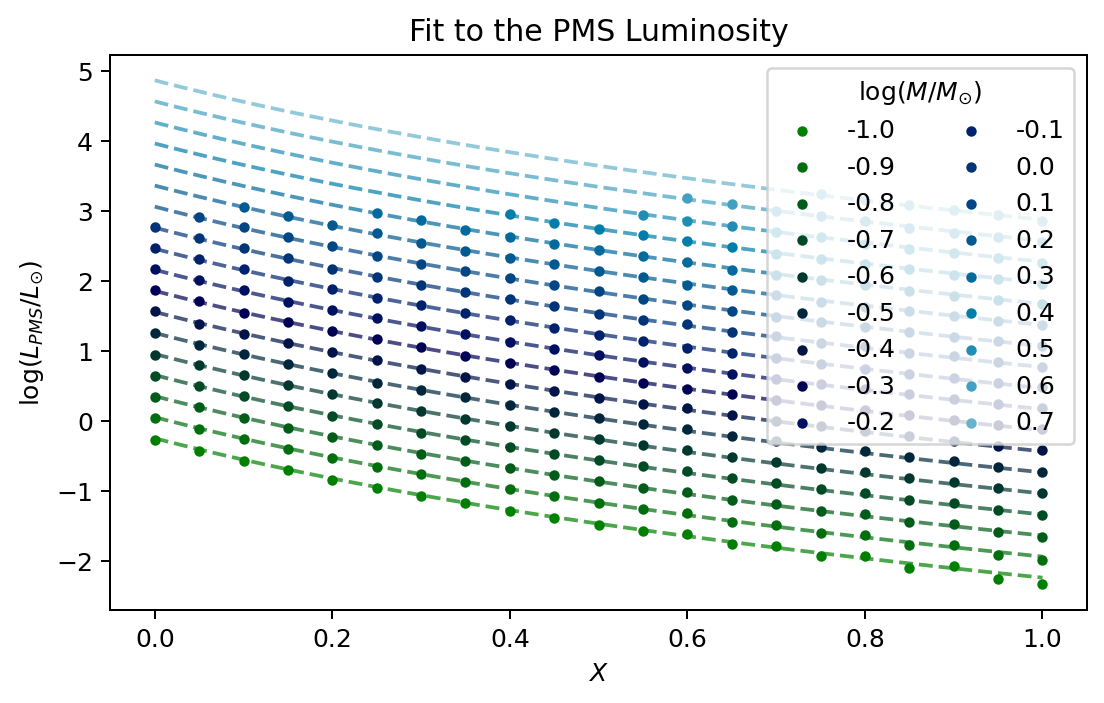

In [220]:
#make plot of the fit
fig, ax = plt.subplots(1,1, figsize=(7,4),dpi=180)
ax.set_title('Fit to the PMS Luminosity')
ax.set_xlabel('$X$')
ax.set_ylabel('$\log(L_{PMS}/L_{\odot})$')

logMrange = unique(goodGrid.logMs)
XRange = np.linspace(0,1,100)
colors = plt.cm.ocean(np.linspace(0.0, 0.8, len(logMrange)))
for logM, color in zip(logMrange,colors):
    cutGrid = goodGrid.collapse_grid_logM(logM)
    ax.scatter(cutGrid.Xs, np.log10(cutGrid.PMS_Ls), label = f'{logM}', marker = 'o',color=color,s=10)
    ax.plot(XRange, fit2.eval(X = XRange, M = 10**logM),alpha = 0.7, ls='--',color=color)
    #uncertainties = fit2.eval_uncertainty(X = X, M = 10**logMrange, sigma=5)
    #ax.fill_between(logMrange, fit2.eval(X = X, M = 10**logMrange) - uncertainties, fit2.eval(X = X, M = 10**logMrange) + uncertainties, alpha = 1, color = 'tab:blue')
ax.legend(title='$\log(M/M_{\odot})$',ncols=2)

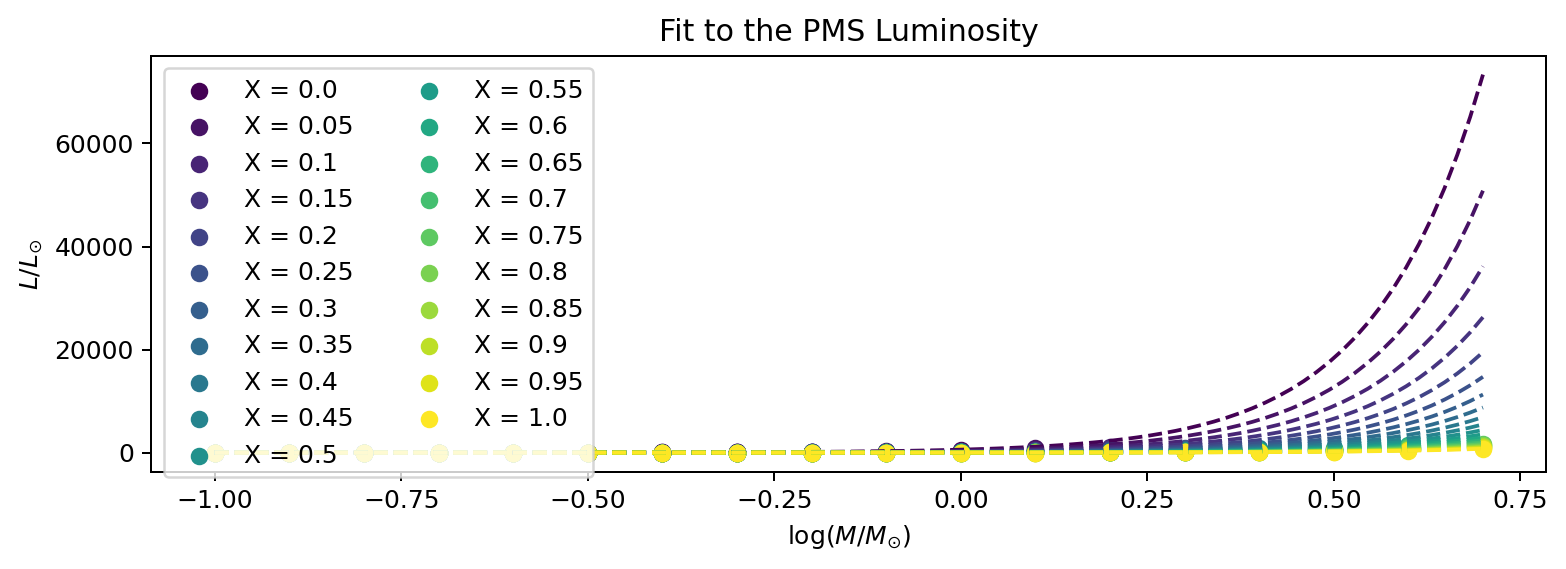

In [221]:
#make plot of the fit
fig, ax = plt.subplots(1,1, figsize=(10,3),dpi=180)
ax.set_title('Fit to the PMS Luminosity')
ax.set_xlabel('$\log(M/M_{\odot})$')
ax.set_ylabel('$L / L_{\odot}$')

logMrange = np.linspace(-1,0.7,100)
Xs = unique(goodGrid.Xs)
#Xs = [0.6,0.7,0.9]
colors = plt.cm.viridis(np.linspace(0, 1, len(Xs)))
for X, color in zip(Xs,colors):
    cutGrid = goodGrid.collapse_grid_X(X)
    ax.scatter(cutGrid.logMs, cutGrid.PMS_Ls, label = f'X = {X}', marker = 'o',color=color)
    ax.plot(logMrange, 10**fit2.eval(X = X, M = 10**logMrange), ls='--',color=color)
    #uncertainties = fit2.eval_uncertainty(X = X, M = 10**logMrange, sigma=5)
    #ax.fill_between(logMrange, fit2.eval(X = X, M = 10**logMrange) - uncertainties, fit2.eval(X = X, M = 10**logMrange) + uncertainties, alpha = 1, color = 'tab:blue')
ax.legend(ncols=2, loc='upper left')

## Fitting for each X fixed

Model: $ \log L( \log M) = c + \alpha \log M$

In [222]:
def logL_model(logM, c, alpha): return c + alpha*logM 
def do_fit_at_X_fixed(grid, PMS = True):
    model = lmfit.Model(logL_model, independent_vars = ['logM'])
    model.set_param_hint('c', value = 0, min = -10, max = 10)
    model.set_param_hint('alpha', value = 3, min = -10, max = 10)
    if PMS: fit = model.fit(np.log10(grid.PMS_Ls), logM = grid.logMs)
    else: fit = model.fit(np.log10(grid.ZAMS_Ls), logM = grid.logMs)
    return fit

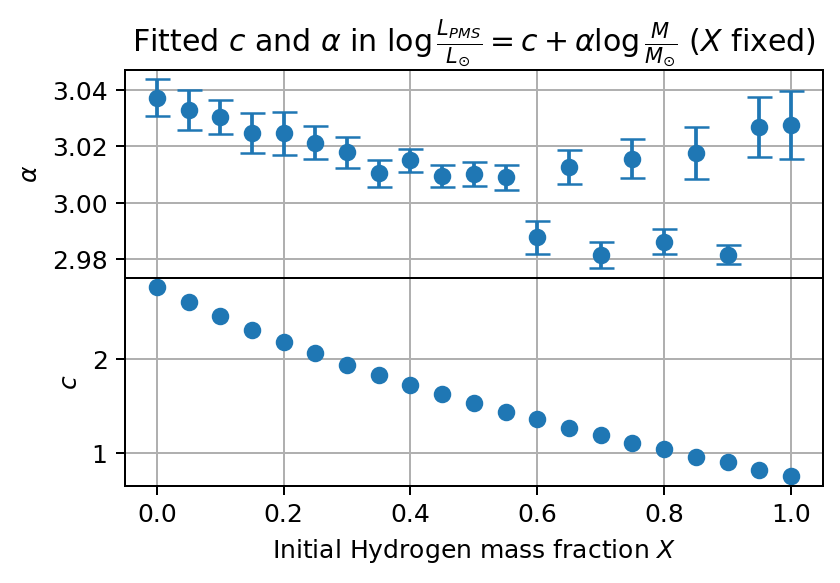

In [223]:
Xrange = unique(goodGrid.Xs)
actualXrange = []
cs = []
alphas = []
for index, X in enumerate(Xrange):
    Xgrid = goodGrid.collapse_grid_X(X) #fix X value in grid
    if len(Xgrid.tracks) == 1: continue
    fit = do_fit_at_X_fixed(Xgrid, True)
    cs.append(fit.params['c'])
    alphas.append(fit.params['alpha'])
    actualXrange.append(X)
fig, axes = plt.subplots(2,1, figsize = (5,3), dpi = 180,sharex=True)
#remove witespace between subplots
fig.subplots_adjust(hspace=0.0)
axes[0].errorbar(actualXrange, [alpha.value for alpha in alphas],yerr = [alpha.stderr for alpha in alphas], fmt = 'o', capsize=5)
#axes[0].axhline(3.0, ls='--')
axes[0].set_ylabel('$\\alpha$')
axes[0].set_title('Fitted $c$ and $\\alpha$ in $\log \\frac{L_{PMS}}{L_{\odot}} = c + \\alpha \log \\frac{M}{M_{\odot}}$ ($X$ fixed)')
axes[1].set_xlabel('Initial Hydrogen mass fraction $X$')
#axes[1].errorbar(Xrange, [c.value for c in cs],yerr = [c.stderr for c in cs], fmt = 'o', capsize=5)
axes[1].set_ylabel('$c$')
axes[0].grid()
axes[1].grid()
axes[1].set_axisbelow(True)
#axes[1].scatter(Xrange, [10**c.value for c in cs], color='tab:blue')
axes[1].scatter(actualXrange, [c.value for c in cs], color='tab:blue')

### Fixed M, fit for each M

No using the model $L = f(X(\mu)) M^3$. And $L \propto \frac{1}{\kappa} \mu^4 M^3$, hence $f \propto \mu^4 / \kappa$.

Define $f(X) \equiv \frac{1}{(3+5X)^4(1+X)} $, simply calculate from $X$.
If we then, for a fixed mass, plot $\log L$ as a function of $f(X)$, we should be able to model that using
$\log L = intercept(M) + slope \times \log f(X)$, where we want that $slope =1$. The intercept is still a function of $M$, but we only do fits in slices of constant $M$.

In [224]:
def linear(x, slope, intercept): return slope*x + intercept
def do_linear_fit(Y, X):
    model = lmfit.Model(linear, independent_vars = ['x'])
    model.set_param_hint('slope', value = 0, min = -10, max = 20)
    model.set_param_hint('intercept', value = 0, min = -20, max = 20)
    fit = model.fit(Y, x = X)
    return fit

Text(-3, -1.55, '$X = 1$')

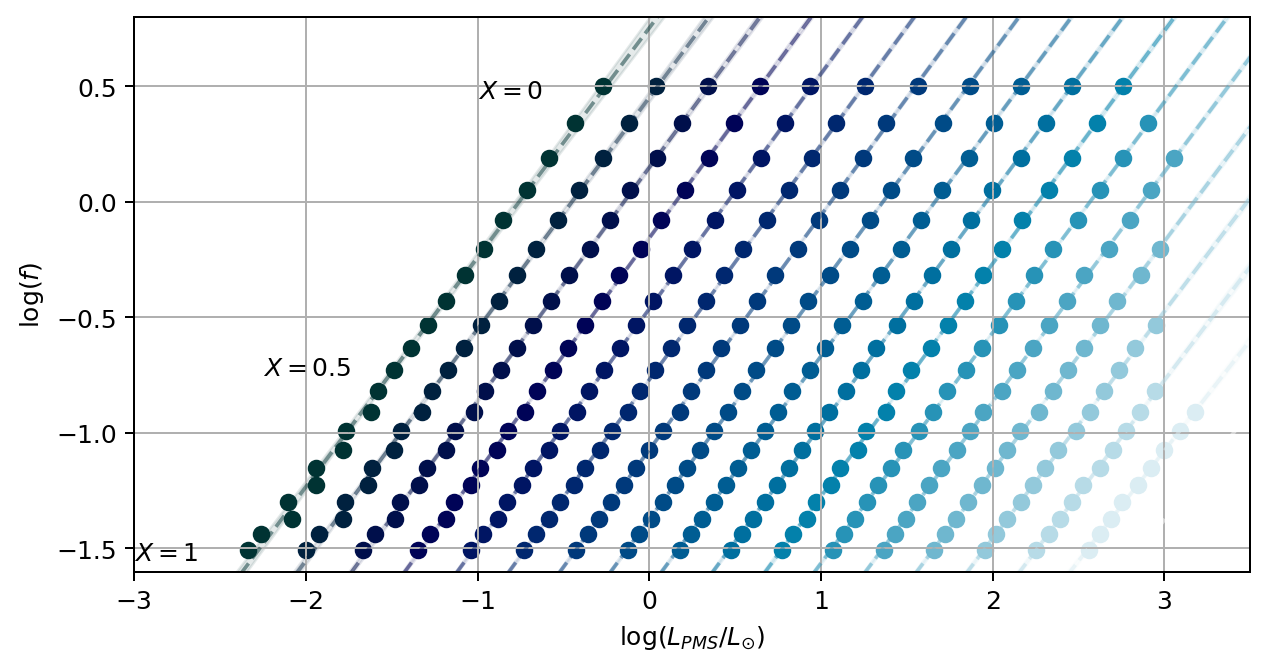

In [225]:
fig, ax = plt.subplots(1,1, figsize = (8,4), dpi = 180)
logMRange = unique(goodGrid.logMs)
colors = plt.cm.ocean(np.linspace(0.2, 1, len(logMRange)))
slopes = []
for logM, color in zip(logMRange, colors):
    logMGrid = goodGrid.collapse_grid_logM(logM)
    f = logMGrid.µs ** 4 / (1 + logMGrid.Xs)
    ax.scatter(np.log10(logMGrid.PMS_Ls) , np.log10(f), color = color)
    fit = do_linear_fit(np.log10(f), np.log10(logMGrid.PMS_Ls))
    slopes.append(fit.params['slope'])
    logLRange = np.linspace(-3,4, 100)
    ax.plot(logLRange, fit.eval(x = logLRange), color = color,ls='--',alpha=0.5)
    uncertainties = fit.eval_uncertainty(x = logLRange, sigma=2)
    ax.fill_between(logLRange, fit.eval(x = logLRange) - uncertainties, fit.eval(x = logLRange) + uncertainties, alpha = 0.1, color = color)
ax.set_xlabel('$\log(L_{PMS}/L_{\odot})$')                              
ax.set_ylabel('$\log(f)$')                              
ax.grid()                               
ax.set_ylim(-1.6,0.8)                               
ax.set_xlim(-3,3.5)        


ax.text(-1, 0.45, '$X = 0$')
ax.text(-2.25, -0.75, '$X = 0.5$')
ax.text(-3, -1.55, '$X = 1$')

In [226]:
def axlabels_helpfunction(ax): 
    ax.text(-1.68,-2.47, '$-1.0$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-2.17, '$-0.9$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-1.87, '$-0.8$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-1.57, '$-0.7$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-1.27, '$-0.6$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-0.97, '$-0.5$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-0.67, '$-0.4$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-0.37, '$-0.3$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,-0.07, '$-0.2$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,0.23, '$-0.1$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,0.53, '$0.0$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,0.83, '$0.1$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,1.13, '$0.2$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,1.43, '$0.3$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,1.73, '$0.4$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,2.03, '$0.5$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,2.33, '$0.6$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    ax.text(-1.68,2.63, '$0.7$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    #ax.text(-1.68,2.93, '$0.8$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    #ax.text(-1.68,3.23, '$0.9$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)
    #ax.text(-1.68,3.53, '$1.0$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)

Text(-1.78, 3, '$ \\log (M/M_{\\odot})$')

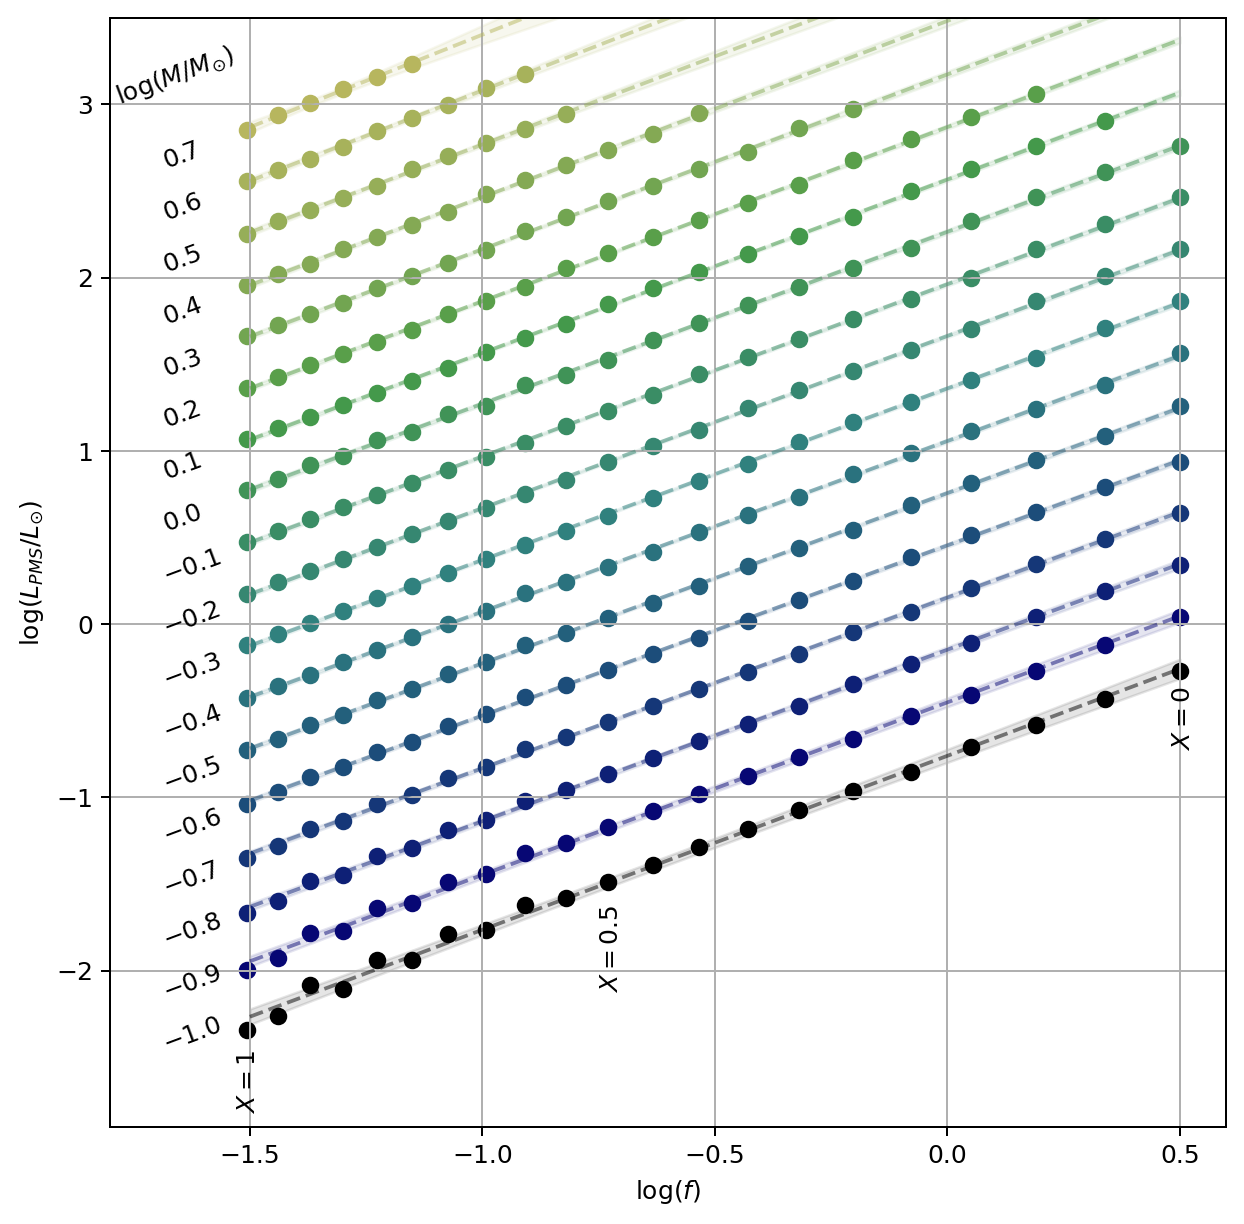

In [227]:
fig, ax = plt.subplots(1,1, figsize = (8,8), dpi = 180)
logMRange = unique(goodGrid.logMs)
colors = plt.cm.gist_earth(np.linspace(0, 0.7, len(logMRange)))
slopes = []
for logM, color in zip(logMRange, colors):
    logMGrid = goodGrid.collapse_grid_logM(logM)
    f = logMGrid.µs ** 4 / (1 + logMGrid.Xs)
    ax.scatter(np.log10(f),np.log10(logMGrid.PMS_Ls), color = color)
    fit = do_linear_fit(np.log10(logMGrid.PMS_Ls),np.log10(f))
    slopes.append(fit.params['slope'])
    fRange = np.linspace(-1.5,0.50,100)
    ax.plot(fRange, fit.eval(x = fRange), color = color, ls='--', alpha=0.5)
    uncertainties = fit.eval_uncertainty(x = fRange, sigma=3)
    ax.fill_between(fRange, fit.eval(x = fRange) - uncertainties, fit.eval(x = fRange) + uncertainties, alpha = 0.1, color = color)
    #ax.fill_between(logLRange, fit.eval(x = logLRange) - uncertainties, fit.eval(x = logLRange) + uncertainties, alpha = 0.1, color = color)
ax.set_ylabel('$\log(L_{PMS}/L_{\odot})$')                              
ax.set_xlabel('$\log(f)$')                              
ax.grid()                               
ax.set_xlim(-1.8,0.6)                               
ax.set_ylim(-2.9,3.5)        


ax.text(0.48,-0.7, '$X = 0$',rotation=90)
ax.text(-0.75,-2.1, '$X = 0.5$', rotation=90)
ax.text(-1.53, -2.8,'$X = 1$', rotation=90)

axlabels_helpfunction(ax)
ax.text(-1.78, 3, '$ \log (M/M_{\odot})$',rotation=45,rotation_mode='anchor',transform_rotates_text=True)



Text(0, 0.5, 'Slope')

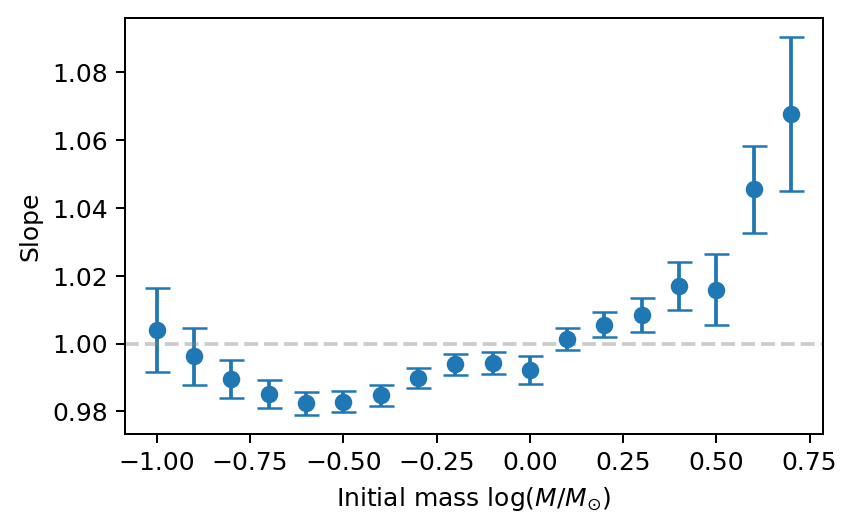

In [228]:
fig, ax = plt.subplots(1,1, figsize = (5,3), dpi = 180)                 
ax.errorbar(logMRange, [slope.value for slope in slopes],yerr = [slope.stderr for slope in slopes], fmt = 'o', capsize=5)                 
ax.axhline(1.0, ls='--',color='gray',alpha=0.4)                 
ax.set_xlabel('Initial mass $\log(M/M_{\odot})$')                 
ax.set_ylabel('Slope')                 

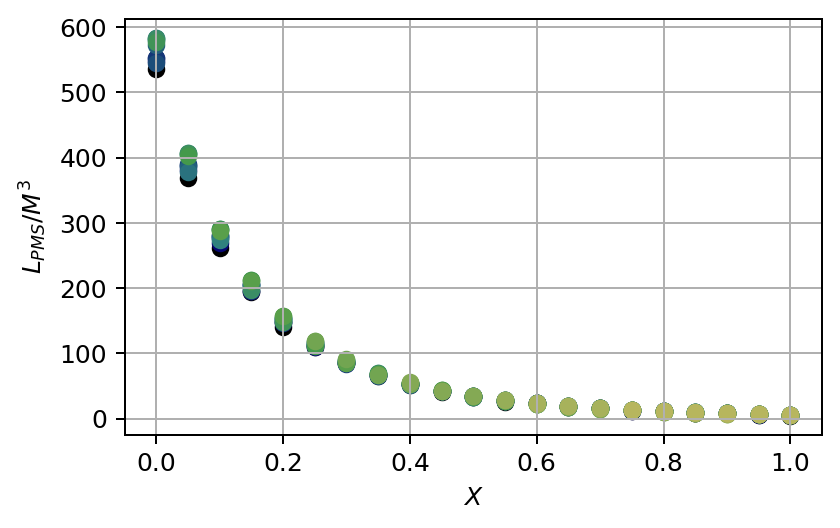

In [229]:
fig, ax = plt.subplots(1,1, figsize = (5,3), dpi = 180)
logMRange = unique(goodGrid.logMs)
colors = plt.cm.gist_earth(np.linspace(0, 0.7, len(logMRange)))
for logM, color in zip(logMRange, colors):
    logMGrid = goodGrid.collapse_grid_logM(logM)
    f = logMGrid.PMS_Ls / ((10**logM)**3)
    ax.scatter(logMGrid.Xs, f, color = color)
    #fit = do_linear_fit(np.log10(logMGrid.PMS_Ls),np.log10(f))
    #slopes.append(fit.params['slope'])
    #fRange = np.linspace(-1.5,0.50,100)
    #ax.plot(fRange, fit.eval(x = fRange), color = color, ls='--', alpha=0.5)
    #uncertainties = fit.eval_uncertainty(x = fRange, sigma=3)
    #ax.fill_between(fRange, fit.eval(x = fRange) - uncertainties, fit.eval(x = fRange) + uncertainties, alpha = 0.1, color = color)
    #ax.fill_between(logLRange, fit.eval(x = logLRange) - uncertainties, fit.eval(x = logLRange) + uncertainties, alpha = 0.1, color = color)
ax.set_ylabel('$L_{PMS} / M^3$')                              
ax.set_xlabel('$X$')                            
ax.grid()       